In [1]:
import pandas as pd
import numpy as np
from technical_indicators_lib import *
import yfinance as yf
import math
from ta.momentum import WilliamsRIndicator
import matplotlib.pyplot as plt

In [250]:
# Simple Average Movement 
def get_smas(stocks, names, period):
    sma = SMA()
    for stock in stocks:
        stock = sma.get_value_df(stock, period)
    #print(stocks)
    add_buy_and_sell_sma(stocks)
    print_smas(stocks, names)
    
def add_buy_and_sell_sma(stocks):
    for stock in stocks:
        trend = []
        helper_buy = []
        helper_sell = []
        flag = 0
        days_signal_persists = 0
        for day in stock.index:
            if math.isnan(stock["SMA"][day]): 
                helper_buy.append(np.nan)
                helper_sell.append(np.nan)
                trend.append("hold")
            else:    
                if stock["close"][day] > stock["SMA"][day]:
                    if flag == 0:
                        days_signal_persists = 0
                        helper_buy.append(np.nan)
                        helper_sell.append(np.nan)
                        trend.append("hold")
                        flag = 1
                    else:
                        days_signal_persists+=1
                        if (days_signal_persists >= 2  and days_signal_persists < 6):
                            helper_buy.append(stock["close"][day])
                            helper_sell.append(np.nan)
                            trend.append("buy")
                        else:
                            helper_sell.append(np.nan)
                            helper_buy.append(np.nan)
                            trend.append("hold")        
                if stock["close"][day] <= stock["SMA"][day]:
                    if flag == 1:
                        days_signal_persists=0
                        helper_sell.append(np.nan)
                        helper_buy.append(np.nan)
                        flag = 0
                        trend.append("hold")
                    else:
                        days_signal_persists+=1
                        if (days_signal_persists >= 2 and days_signal_persists < 6): 
                            helper_buy.append(np.nan)
                            helper_sell.append(stock["close"][day])
                            trend.append("sell")
                        else:
                            helper_sell.append(np.nan)
                            helper_buy.append(np.nan)
                            trend.append("hold")  
        stock["sma_buy"] = helper_buy
        stock["sma_sell"] = helper_sell
        stock["sma_trend"] = trend
        
def print_smas(stocks, names):
    counter = 0
    for stock in stocks:
        fig, ax = plt.subplots(figsize=(15,10))  # Create a figure and an axes.
        ax.plot(stock["close"], label="close")  # Plot some data on the axes.
        ax.plot(stock["sma_buy"], label="buy", marker=10, color="g")
        ax.plot(stock["sma_sell"], label="sell", marker=11, color="r")
        ax.set_xlabel('Time')  # Add an x-label to the axes.
        ax.set_ylabel('Value')  # Add a y-label to the axes.
        ax.set_title("SMA of "+names[counter])  # Add a title to the axes.
        ax.legend()  # Add a legend.
        counter+=1

In [251]:
# Relative Strength Index

def get_rsi(stocks, names, period):
    rsi = RSI()
    for stock in stocks:
        stock = rsi.get_value_df(stock, period)
    #print(stocks)
    add_buy_and_sell_rsi(stocks)
    print_rsi(stocks, names)

def add_buy_and_sell_rsi(stocks):
     for stock in stocks:
        trend = []
        helper_buy = []
        helper_sell = []
        flag = 0
        days_signal_persists = 0
        for day in stock.index:
            if math.isnan(stock["RSI"][day]): 
                helper_buy.append(np.nan)
                helper_sell.append(np.nan)
                trend.append("hold")
            else:    
                if stock["RSI"][day] <= 33:
                    if flag == 0:
                        days_signal_persists = 0
                        helper_buy.append(np.nan)
                        helper_sell.append(np.nan)
                        flag = 1
                        trend.append("hold")
                    else:
                        days_signal_persists+=1
                        if days_signal_persists >= 4:
                            helper_buy.append(stock["close"][day])
                            helper_sell.append(np.nan)
                            trend.append("buy")
                        else:
                            helper_buy.append(np.nan)
                            helper_sell.append(np.nan)
                            trend.append("hold")
                if stock["RSI"][day] >= 70:
                    if flag == 1:
                        days_signal_persists = 0
                        helper_sell.append(np.nan)
                        helper_buy.append(np.nan)
                        trend.append("hold")
                        flag = 0
                    else:
                        days_signal_persists+=1
                        if days_signal_persists >= 10:
                            helper_buy.append(np.nan)
                            helper_sell.append(stock["close"][day])
                            trend.append("sell")
                        else:
                            helper_buy.append(np.nan)
                            helper_sell.append(np.nan)
                            trend.append("hold")                        
                if  stock["RSI"][day] < 70 and stock["RSI"][day] > 33:
                    helper_sell.append(np.nan)
                    helper_buy.append(np.nan)
                    trend.append("hold")
        stock["rsi_buy"] = helper_buy
        stock["rsi_sell"] = helper_sell
        stock["rsi_trend"] = trend

def print_rsi(stocks, names):
    counter = 0
    for stock in stocks:
        fig, ax = plt.subplots(figsize=(15,10))  # Create a figure and an axes.
        ax.plot(stock["close"], label="close")  # Plot some data on the axes.
        ax.plot(stock["rsi_buy"], label="buy", marker=10, color="g")
        ax.plot(stock["rsi_sell"], label="sell", marker=11, color="r")
        ax.set_xlabel('Time')  # Add an x-label to the axes.
        ax.set_ylabel('Value')  # Add a y-label to the axes.
        ax.set_title("RSI of "+names[counter])  # Add a title to the axes.
        ax.legend()  # Add a legend.
        counter+=1

In [252]:
# MACD
def get_macd(stocks, names, period):
    macd = MACD()
    for stock in stocks:
        stock = macd.get_value_df(stock, 12, 26, True, 9)
    #print(stocks)
    add_buy_and_sell_macd(stocks)
    print_macd(stocks, names)

    # macd needs both holds since only crosses are taking effect

def add_buy_and_sell_macd(stocks):
     for stock in stocks:
        trend = []
        helper_buy = []
        helper_sell = []
        flag = 0
        days_signal_persists = 0
        for day in stock.index:
            if math.isnan(stock["MACD_signal_line"][day]) or math.isnan(stock["MACD"][day]): 
                helper_buy.append(np.nan)
                helper_sell.append(np.nan)
                trend.append("hold")
            else:   
                    if (stock["MACD"][day] <= stock["MACD_signal_line"][day]):
                        if flag == 1:
                            days_signal_persists=0
                            helper_sell.append(np.nan)
                            helper_buy.append(np.nan)
                            trend.append("hold")
                            flag = 0
                        else:
                            days_signal_persists+=1
                            if days_signal_persists >= 1 and days_signal_persists < 5:
                                helper_buy.append(np.nan)
                                helper_sell.append(stock["close"][day])
                                trend.append("sell")
                            else:
                                helper_sell.append(np.nan)
                                helper_buy.append(np.nan)
                                trend.append("hold")                                
                    elif stock["MACD"][day] > stock["MACD_signal_line"][day]:                               
                        if flag == 0:
                            days_signal_persists = 0
                            helper_buy.append(np.nan)
                            helper_sell.append(np.nan)
                            flag = 1
                            trend.append("hold")
                        else:
                            days_signal_persists+=1
                            if days_signal_persists >= 1 and days_signal_persists < 5:
                                helper_buy.append(stock["close"][day])
                                helper_sell.append(np.nan)
                                trend.append("buy")
                            else:
                                helper_sell.append(np.nan)
                                helper_buy.append(np.nan)
                                trend.append("hold")
        stock["macd_buy"] = helper_buy
        stock["macd_sell"] = helper_sell
        stock["macd_trend"] = trend
def print_macd(stocks, names):
    counter = 0
    for stock in stocks:
        fig, ax = plt.subplots(figsize=(15,10))  # Create a figure and an axes.
        ax.plot(stock["close"], label="close")  # Plot some data on the axes.
        ax.plot(stock["macd_buy"], label="buy", marker=10, color="g")
        ax.plot(stock["macd_sell"], label="sell", marker=11, color="r")
        ax.set_xlabel('Time')  # Add an x-label to the axes.
        ax.set_ylabel('Value')  # Add a y-label to the axes.
        ax.set_title("MACD of "+names[counter])  # Add a title to the axes.
        ax.legend()  # Add a legend.
        counter+=1

In [253]:
# EMA EMA
def get_ema(stocks, names, period):
    ema = EMA()
    for stock in stocks:
        stock = ema.get_value_df(stock, period)
    add_buy_and_sell_ema(stocks)
    print_ema(stocks, names)
        
def add_buy_and_sell_ema(stocks):
     for stock in stocks:
        trend = []
        helper_buy = []
        helper_sell = []
        flag = 0
        days_signal_persists = 0
        for day in stock.index:
            if math.isnan(stock["EMA"][day]): 
                helper_buy.append(np.nan)
                helper_sell.append(np.nan)
                trend.append("hold")
            else:    
                if stock["EMA"][day] <= stock["close"][day]:
                    if flag == 0:
                        days_signal_persists = 0
                        helper_buy.append(np.nan)
                        helper_sell.append(np.nan)
                        flag = 1
                        trend.append("hold")
                    else:
                        days_signal_persists+=1
                        if days_signal_persists >= 4  and days_signal_persists < 7:
                            helper_buy.append(stock["close"][day])
                            helper_sell.append(np.nan)
                            trend.append("buy")
                        else:
                            helper_sell.append(np.nan)
                            helper_buy.append(np.nan)
                            trend.append("hold")        
                if stock["EMA"][day] > stock["close"][day]:
                    if flag == 1:
                        days_signal_persists = 0
                        helper_sell.append(np.nan)
                        helper_buy.append(np.nan)
                        trend.append("hold")
                        flag = 0
                    else:
                        days_signal_persists+=1
                        if days_signal_persists >= 4 and stock["close"][day] < 7:
                            helper_buy.append(np.nan)
                            helper_sell.append(stock["close"][day])
                            trend.append("sell")
                        else:
                            helper_sell.append(np.nan)
                            helper_buy.append(np.nan)
                            trend.append("hold")        
        stock["ema_buy"] = helper_buy
        stock["ema_sell"] = helper_sell
        stock["ema_trend"] = trend
        
def print_ema(stocks, names):
    counter = 0
    for stock in stocks:
        fig, ax = plt.subplots(figsize=(15,10))  # Create a figure and an axes.
        ax.plot(stock["close"], label="close")  # Plot some data on the axes.
        ax.plot(stock["ema_buy"], label="buy", marker=10, color="g")
        ax.plot(stock["ema_sell"], label="sell", marker=11, color="r")
        ax.set_xlabel('Time')  # Add an x-label to the axes.
        ax.set_ylabel('Value')  # Add a y-label to the axes.
        ax.set_title("EMA of "+names[counter])  # Add a title to the axes.
        ax.legend()  # Add a legend.
        counter+=1

In [254]:
# Stochastik StochasticKAndD
def get_stoch(stocks, names, period):
    stoch = StochasticKAndD()
    for stock in stocks:
        stock = stoch.get_value_df(stock, period)
    #print(stocks)
    add_buy_and_sell_stoch(stocks)
    print_stoch(stocks, names)


def add_buy_and_sell_stoch(stocks):
     for stock in stocks:
        trend = []
        helper_buy = []
        helper_sell = []
        flag = 0
        days_signal_persists = 0
        for day in stock.index:
            if math.isnan(stock["stoc_d"][day]) or math.isnan(stock["stoc_k"][day]): 
                helper_buy.append(np.nan)
                helper_sell.append(np.nan)
                trend.append("hold")
            else:   
                if stock["stoc_k"][day] <= 20 or stock["stoc_d"][day] <= 20:
                    if flag == 0:
                        days_signal_persists = 0
                        helper_buy.append(np.nan)
                        helper_sell.append(np.nan)
                        flag = 1
                        trend.append("hold")
                    else:
                        days_signal_persists+=1
                        if days_signal_persists > 3 and days_signal_persists < 8 :
                            helper_buy.append(stock["close"][day])
                            helper_sell.append(np.nan)
                            trend.append("buy")
                        else:
                            helper_sell.append(np.nan)
                            helper_buy.append(np.nan)
                            trend.append("hold")        
                elif stock["stoc_k"][day] >= 80 or stock["stoc_d"][day] >= 80:
                    if flag == 1:
                        days_signal_persists = 0
                        helper_sell.append(np.nan)
                        helper_buy.append(np.nan)
                        trend.append("hold")
                        flag = 0
                    else:
                        days_signal_persists+=1
                        if days_signal_persists > 3 and days_signal_persists < 8:
                            helper_buy.append(np.nan)
                            helper_sell.append(stock["close"][day])
                            trend.append("sell")
                        else:
                            helper_sell.append(np.nan)
                            helper_buy.append(np.nan)
                            trend.append("hold")        
                else:
                    helper_buy.append(np.nan)
                    helper_sell.append(np.nan)
                    trend.append("hold")
        stock["stoch_buy"] = helper_buy
        stock["stoch_sell"] = helper_sell
        stock["stoch_trend"] = trend
        
def print_stoch(stocks, names):
    counter = 0
    for stock in stocks:
        fig, ax = plt.subplots(figsize=(15,10))  # Create a figure and an axes.
        ax.plot(stock["close"], label="close")  # Plot some data on the axes.
        ax.plot(stock["stoch_buy"], label="buy", marker=10, color="g")
        ax.plot(stock["stoch_sell"], label="sell", marker=11, color="r")
        ax.set_xlabel('Time')  # Add an x-label to the axes.
        ax.set_ylabel('Value')  # Add a y-label to the axes.
        ax.set_title("Stochastik K%D of "+names[counter])  # Add a title to the axes.
        ax.legend()  # Add a legend.
        counter+=1

In [255]:
# create chart for displaying all indicators
three_day_values = [0, 0, 0]
def merge(stocks, names):
    for stock in stocks:
        data=[stock["macd_trend"], stock["rsi_trend"], stock["sma_trend"], stock["ema_trend"], stock["stoch_trend"]]
        headers=["macd_trend", "rsi_trend", "sma_trend", "ema_trend", "stoch_trend"]
    
        helper = pd.concat(data, axis=1, keys=headers)
        length = len(data[0])
        buy_weak = []
        buy_middle = []
        buy_strong = []
        hold = []
        sell_weak = []
        sell_middle = []
        sell_strong = []
        three_day_values = [0, 0, 0]

        for x in range(0,length):
            macd = helper.iloc[x]["macd_trend"]
            rsi = helper.iloc[x]["rsi_trend"]
            sma = helper.iloc[x]["sma_trend"]
            ema = helper.iloc[x]["ema_trend"]
            stoch = helper.iloc[x]["stoch_trend"]
            indicators=[macd, rsi, sma, ema, stoch]
            decision = decide(indicators)
            if decision == "buy_weak":
                buy_weak.append(stock.iloc[x]["close"])
                buy_middle.append(np.nan)
                buy_strong.append(np.nan)
                sell_weak.append(np.nan)
                sell_middle.append(np.nan)
                sell_strong.append(np.nan)
                hold.append(np.nan)
            if decision == "buy_middle":
                buy_middle.append(stock.iloc[x]["close"])
                buy_weak.append(np.nan)
                buy_strong.append(np.nan)
                sell_weak.append(np.nan)
                sell_middle.append(np.nan)
                sell_strong.append(np.nan)
                hold.append(np.nan)
            if decision == "buy_strong":
                buy_strong.append(stock.iloc[x]["close"])
                buy_middle.append(np.nan)
                buy_weak.append(np.nan)
                sell_weak.append(np.nan)
                sell_middle.append(np.nan)
                sell_strong.append(np.nan)
                hold.append(np.nan)
            if decision == "sell_weak":
                sell_weak.append(stock.iloc[x]["close"])
                buy_middle.append(np.nan)
                buy_weak.append(np.nan)
                buy_strong.append(np.nan)
                sell_middle.append(np.nan)
                sell_strong.append(np.nan)
                hold.append(np.nan)
            if decision == "sell_middle":
                sell_middle.append(stock.iloc[x]["close"])
                buy_middle.append(np.nan)
                buy_weak.append(np.nan)
                sell_weak.append(np.nan)
                buy_strong.append(np.nan)
                sell_strong.append(np.nan)
                hold.append(np.nan)
            if decision == "sell_strong":
                sell_strong.append(stock.iloc[x]["close"])
                buy_middle.append(np.nan)
                buy_weak.append(np.nan)
                sell_weak.append(np.nan)
                sell_middle.append(np.nan)
                buy_strong.append(np.nan)
                hold.append(np.nan)
            if decision == "hold":
                buy_middle.append(np.nan)
                buy_weak.append(np.nan)
                sell_weak.append(np.nan)
                sell_middle.append(np.nan)
                sell_strong.append(np.nan)
                buy_strong.append(np.nan)
                hold.append(stock.iloc[x]["close"])
        stock["buy_weak"] = buy_weak
        stock["buy_middle"] = buy_middle
        stock["buy_strong"] = buy_strong
        stock["sell_weak"] = sell_weak
        stock["sell_middle"] =sell_middle
        stock["hold"] = hold
        stock["sell_strong"] = sell_strong
    print_all(stocks,names)
            
def decide(indicators):
    helper = 0
    for indicator in indicators:
        if indicator == "buy":
            helper+=1
        if indicator == "sell":
            helper-=1
        if indicator == "hold":
            helper=helper    
    add_to_list(helper)
    rating = get_three_day_rating()
    #print("######################################")
    #print(three_day_values)
    #print(rating)
    #print("######################################")
    #rating = helper
    if rating >= 1 and rating <2: #>= 3 and rating <= 5:
        return "buy_weak"
    elif rating <=3 and rating >= 2: #>= 6 and rating <= 8:
        return "buy_middle"
    elif rating > 3:
        return "buy_strong"
    elif rating <= -1 and rating >2: #<= -3 and rating >= -5:
        return "sell_weak"
    elif rating <= -2 and rating >= -3: #<= -6 and rating >= -8:
        return "sell_middle"
    elif rating < -3:
        return "sell_strong"
    else:
        return "hold"
    
def get_three_day_rating():
    return (three_day_values[0] + three_day_values[1] + three_day_values[2])/3
      
def add_to_list(day_value):
    three_day_values[2] = three_day_values[1]
    three_day_values[1] = three_day_values[0]
    three_day_values[0] = day_value
    
def print_all(stocks, names):
    counter = 0
    for stock in stocks:
        fig, ax = plt.subplots(figsize=(15,10))  # Create a figure and an axes.
        ax.plot(stock["close"], label="close")  # Plot some data on the axes.
        #ax.plot(stock["buy_weak"], label="buy_weak", marker=10, color="y")
        #ax.plot(stock["sell_weak"], label="sell_weak", marker=11, color="m")
        ax.plot(stock["buy_middle"], label="buy_middle", marker=10, color="c")
        ax.plot(stock["sell_middle"], label="sell_middle", marker=11, color="r")
        ax.plot(stock["buy_strong"], label="buy_strong", marker=10, color="g")
        ax.plot(stock["sell_strong"], label="sell_strong", marker=11, color="k")
        #ax.plot(stock["hold"], label="hold", marker=9, color="y")
        ax.set_xlabel('Time')  # Add an x-label to the axes.
        ax.set_ylabel('Value')  # Add a y-label to the axes.
        ax.set_title("All Indicators of "+names[counter])  # Add a title to the axes.
        ax.legend()  # Add a legend.
        counter+=1    

In [305]:
days = "2000d"
#start="2017-01-01", end="2020-01-01"

allianz = "Allianz"
allianz_ticker= yf.Ticker("ALV.DE")
allianz_hist = allianz_ticker.history(start="2017-01-01", end="2020-01-01")
allianz_hist = allianz_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

fresenius = "Fresenius"
fresenius_ticker= yf.Ticker("fre.de")
fresenius_hist = fresenius_ticker.history(start="2017-01-01", end="2020-01-01")
fresenius_hist = fresenius_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

sap = "SAP"
sap_ticker= yf.Ticker("SAP")
sap_hist = sap_ticker.history(start="2017-01-01", end="2020-01-01")
sap_hist = sap_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

verbund = "Verbund AG"
verbund_ticker= yf.Ticker("VER.VI")
verbund_hist = verbund_ticker.history(start="2017-01-01", end="2020-01-01")
verbund_hist = verbund_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

prot = "Protektor Forsikring"
prot_ticker= yf.Ticker("PR4.F")
prot_hist = prot_ticker.history(start="2017-01-01", end="2020-01-01")
prot_hist = prot_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

fuelcell = "FuelCell"
fuelcell_ticker= yf.Ticker("FEY2.BE")
fuelcell_hist = fuelcell_ticker.history(start="2017-01-01", end="2020-01-01")
fuelcell_hist = fuelcell_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

ever = "Ever Fuel"
ever_ticker= yf.Ticker("0HR.BE")
ever_hist = ever_ticker.history(start="2017-01-01", end="2020-01-01")
ever_hist = ever_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

newage = "Newage"
newage_ticker= yf.Ticker("NBEV")
newage_hist = newage_ticker.history(start="2017-01-01", end="2020-01-01")
newage_hist = newage_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

xiamoi = "Xiamoi"
xiamoi_ticker= yf.Ticker("3CP.F")
xiamoi_hist = xiamoi_ticker.history(start="2017-01-01", end="2020-01-01")
xiamoi_hist = xiamoi_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

plug = "Plugpower"
plug_ticker= yf.Ticker("PLUN.BE")
plug_hist = plug_ticker.history(start="2017-01-01", end="2020-01-01")
plug_hist = plug_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

axa = "AXA"
axa_ticker= yf.Ticker("CS.PA")
axa_hist = axa_ticker.history(start="2017-01-01", end="2020-01-01")
axa_hist = axa_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

eon = "EON"
eon_ticker= yf.Ticker("EON.BR")
eon_hist = eon_ticker.history(start="2017-01-01", end="2020-01-01")
eon_hist = eon_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

amp = "AMP"
amp_ticker= yf.Ticker("C4T.BE")
amp_hist = amp_ticker.history(start="2017-01-01", end="2020-01-01")
amp_hist = amp_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})


bayer = "Bayer"
bayer_ticker = yf.Ticker("BAYN.DE")
bayer_hist = bayer_ticker.history(start="2017-01-01", end="2020-01-01")
bayer_hist = bayer_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

basf = "BASF"
basf_ticker = yf.Ticker("BAS.DE")
basf_hist = basf_ticker.history(start="2017-01-01", end="2020-01-01")
basf_hist = basf_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})
######################################

stocks = [allianz_hist, fresenius_hist, sap_hist, verbund_hist, prot_hist, fuelcell_hist, newage_hist, xiamoi_hist, plug_hist, axa_hist, eon_hist, amp_hist, bayer_hist ,basf_hist]
names = [allianz, fresenius, sap, verbund, prot, fuelcell, newage, xiamoi, plug, axa, eon, amp, bayer, basf]


msft = "MSFT"
msft_ticker = yf.Ticker("MSFT")
msft_hist = msft_ticker.history(period=days)
msft_hist = msft_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})
######################################

lh = "LHA.DE"
lh_ticker = yf.Ticker("LHA.DE")
lh_hist = lh_ticker.history(period=days)
lh_hist = lh_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})
######################################

thyssen = "TKA.DE"
thyssen_ticker = yf.Ticker("TKA.DE")
thyssen_hist = thyssen_ticker.history(period=days)
thyssen_hist = thyssen_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})
######################################

san = "SAN"
san_ticker = yf.Ticker("SAN")
san_hist = san_ticker.history(period=days)
san_hist = san_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})
######################################

bp = "BP"
bp_ticker = yf.Ticker("BP")
bp_hist = bp_ticker.history(period=days)
bp_hist = bp_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})
######################################
stocks=[msft_hist, lh_hist, thyssen_hist, san_hist, bp_hist]
names=[msft, lh, thyssen, san, bp]

#print(stocks)

- 0HR.BE: Data doesn't exist for startDate = 1483225200, endDate = 1577833200


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

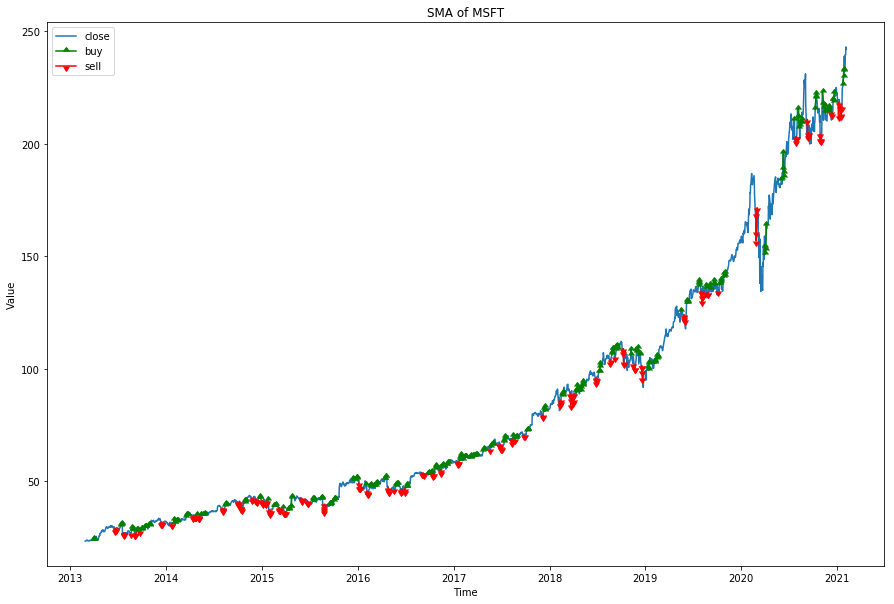

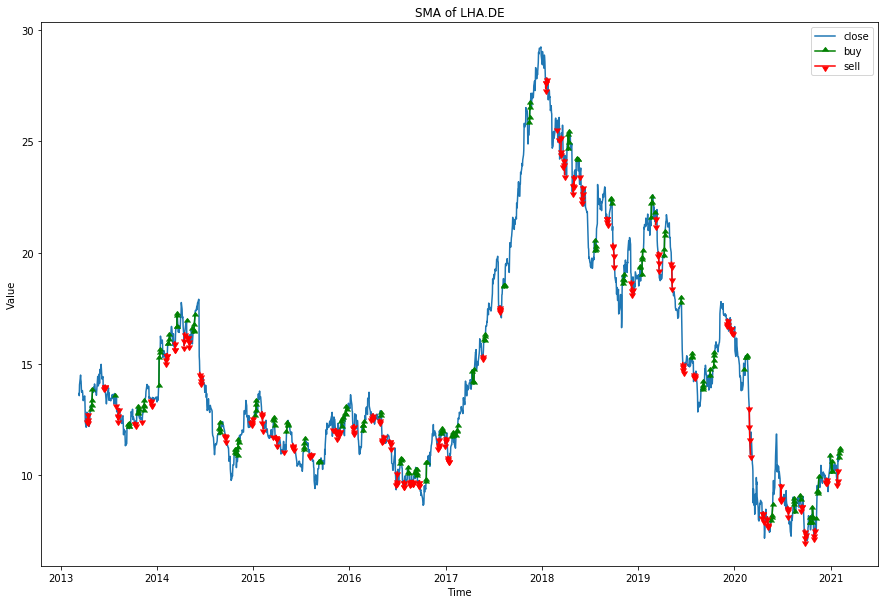

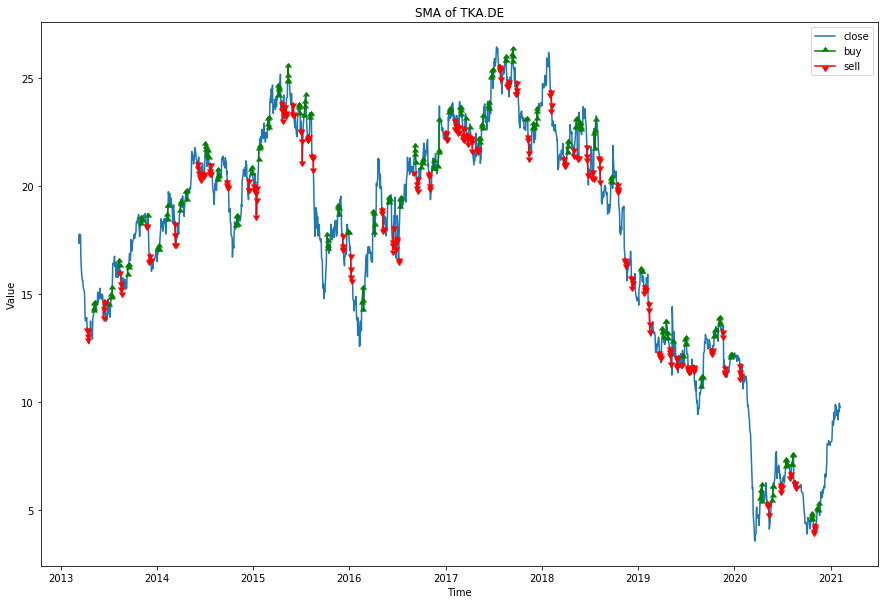

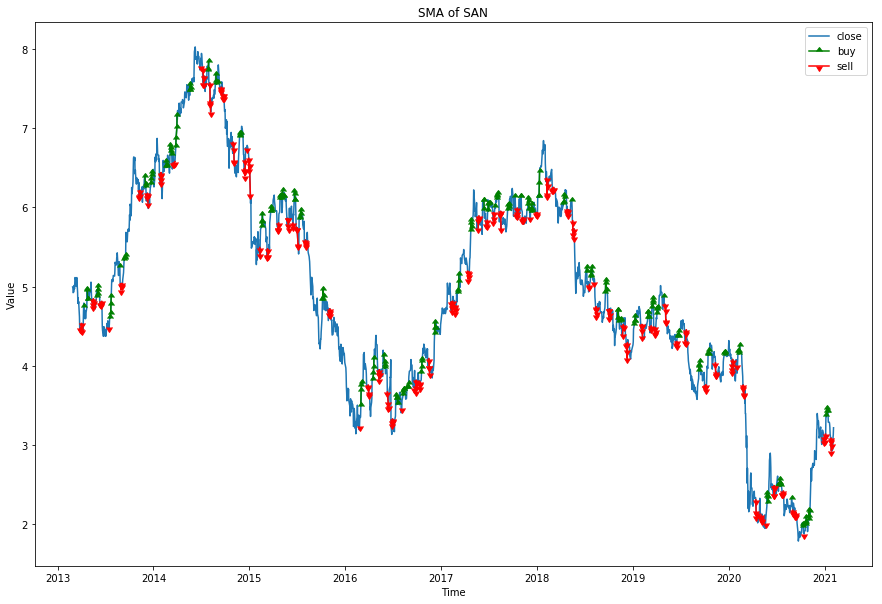

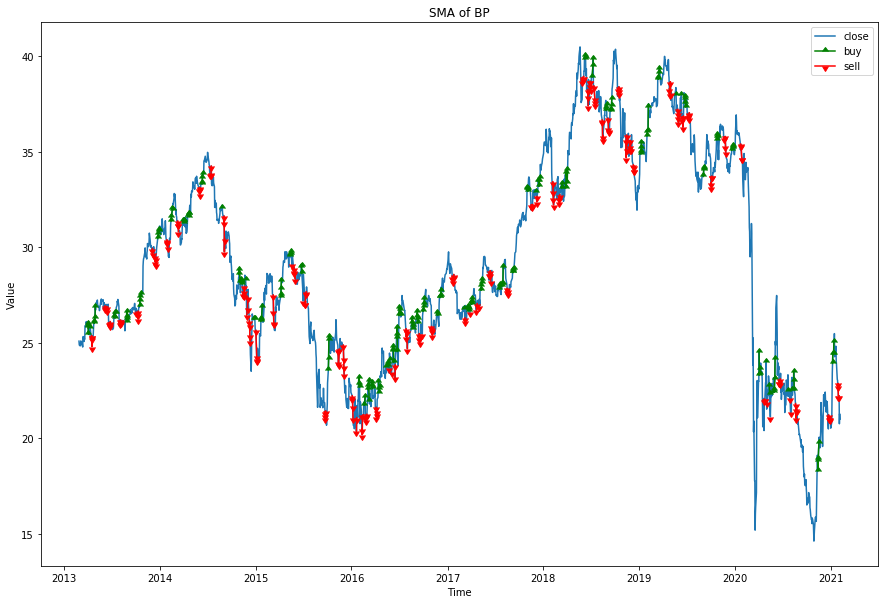

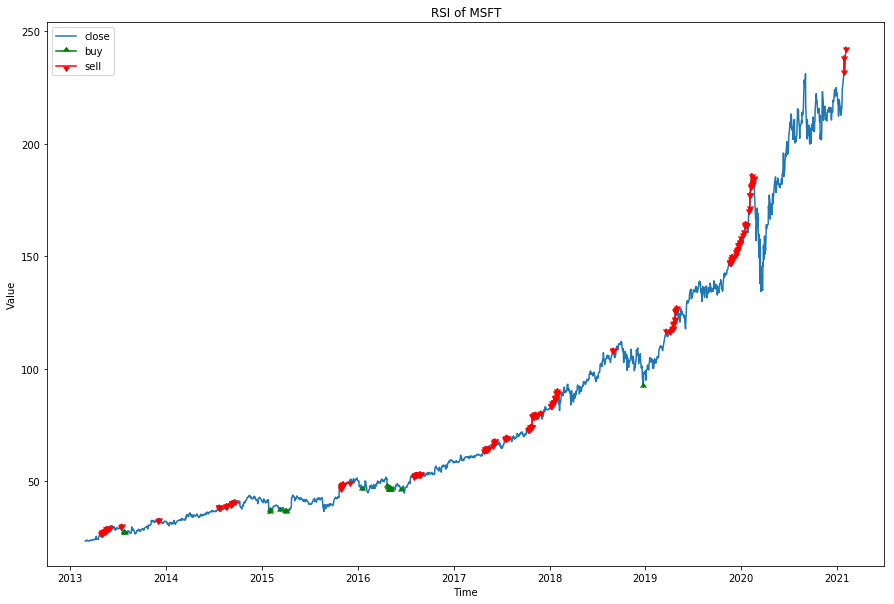

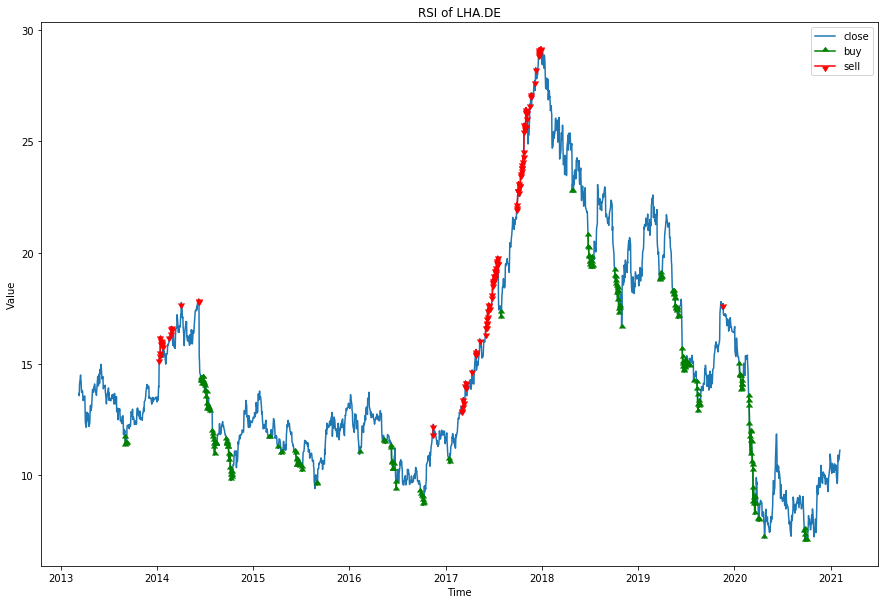

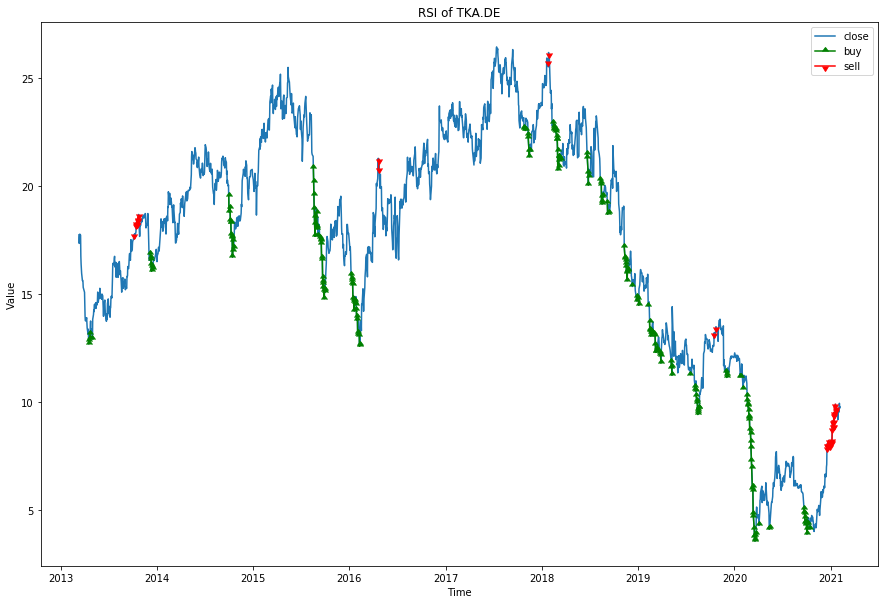

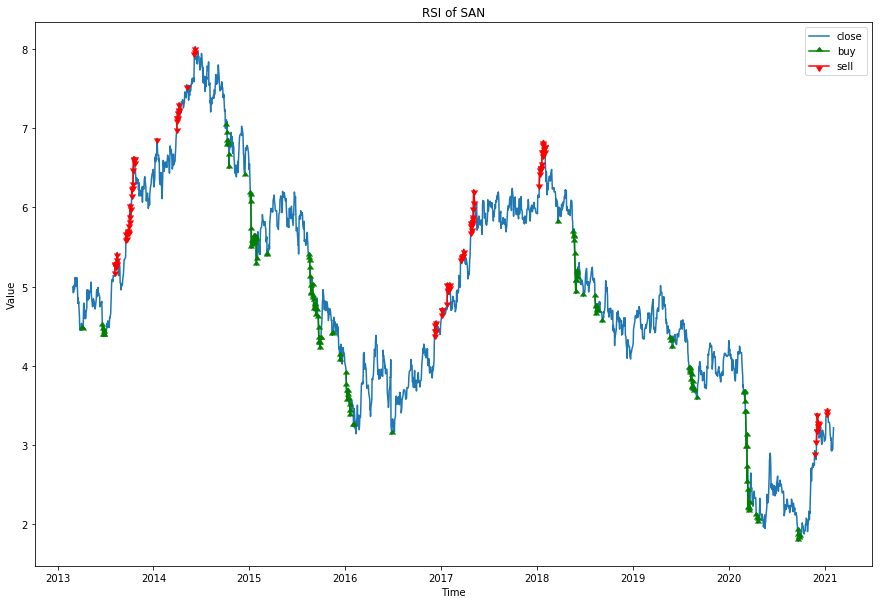

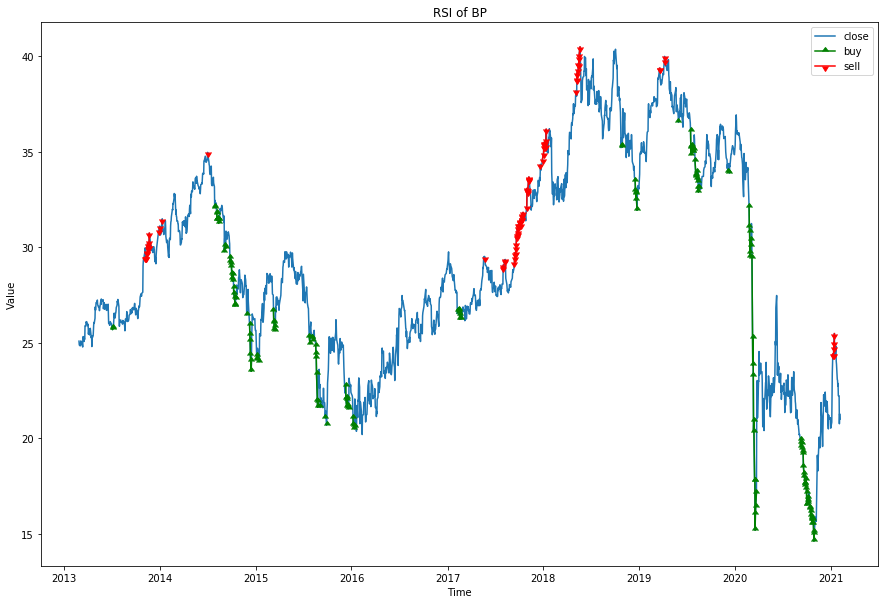

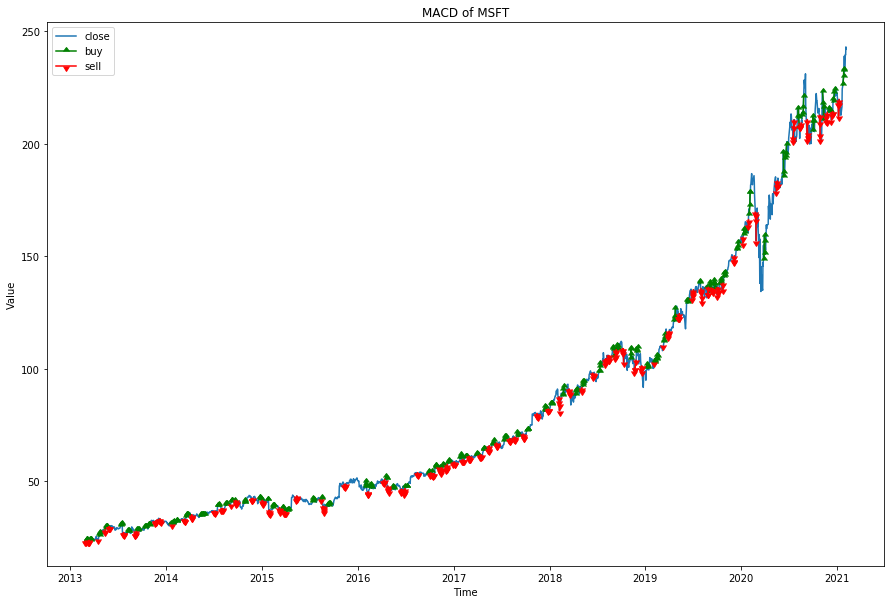

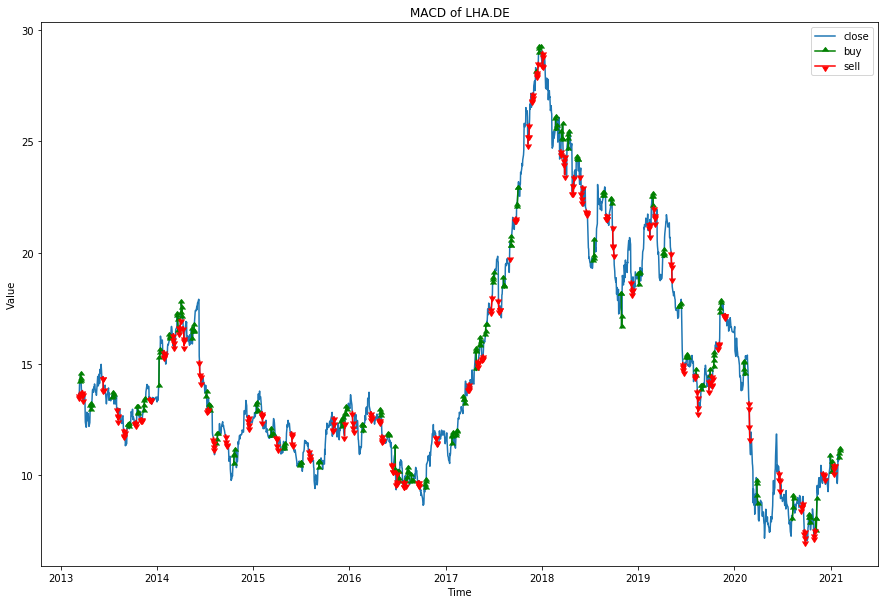

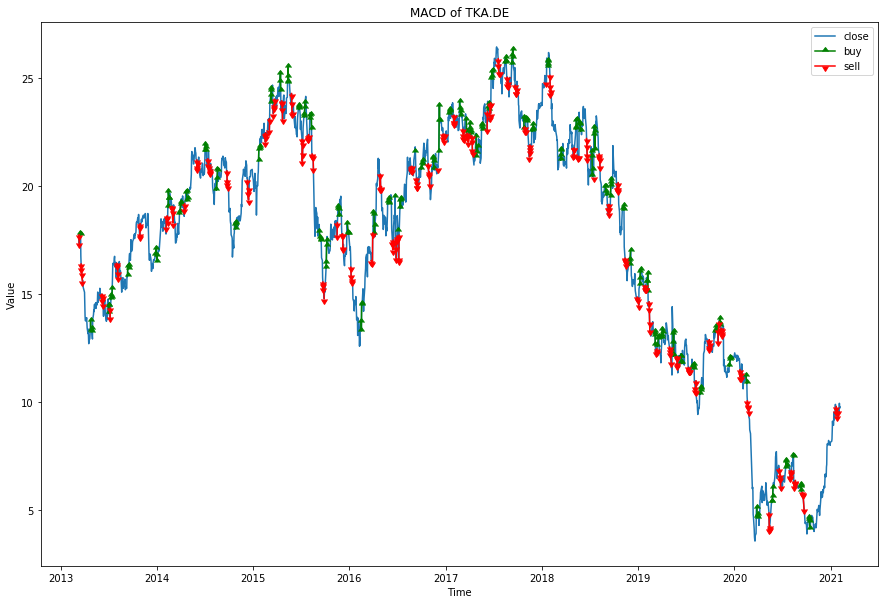

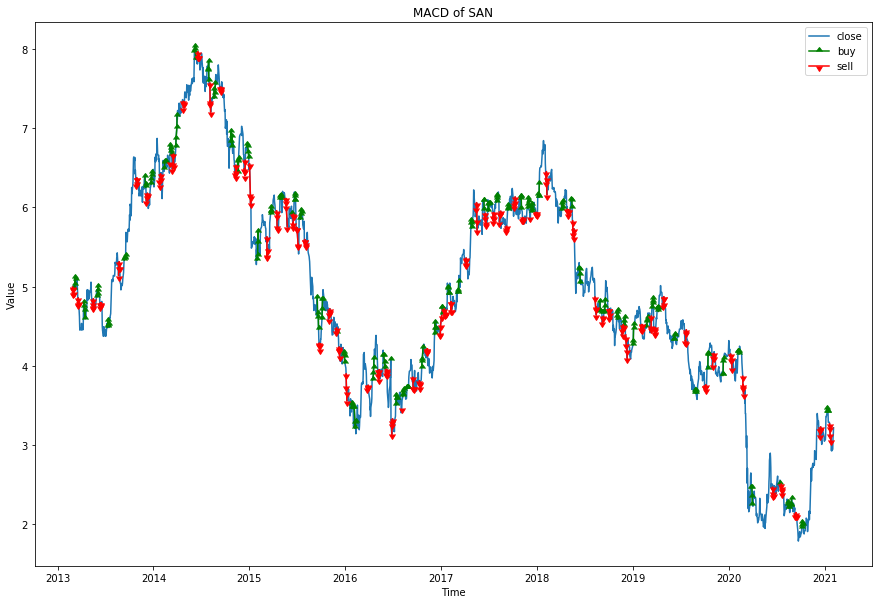

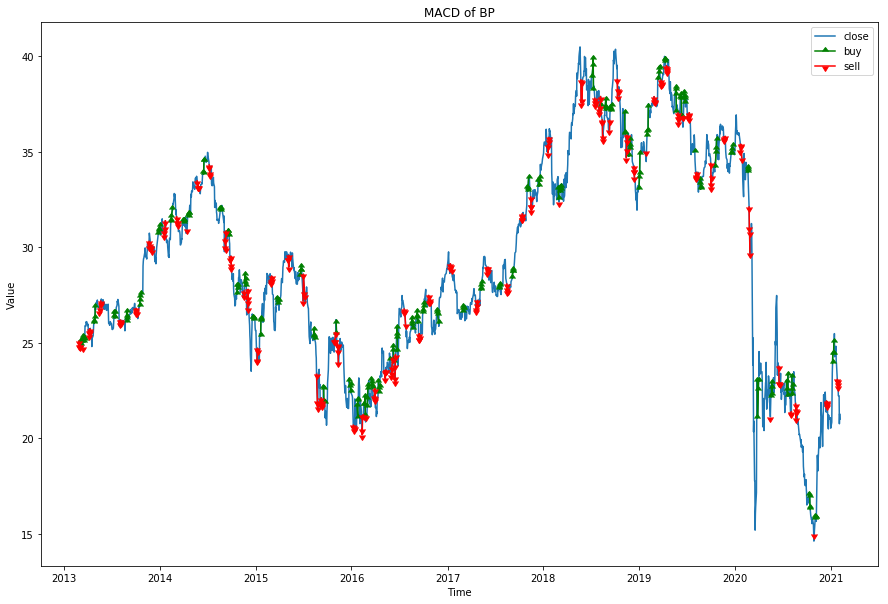

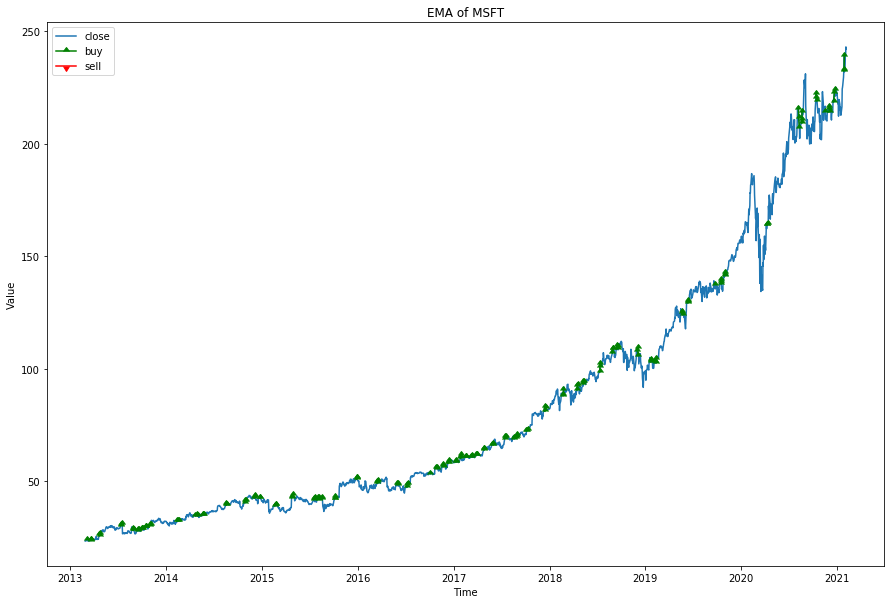

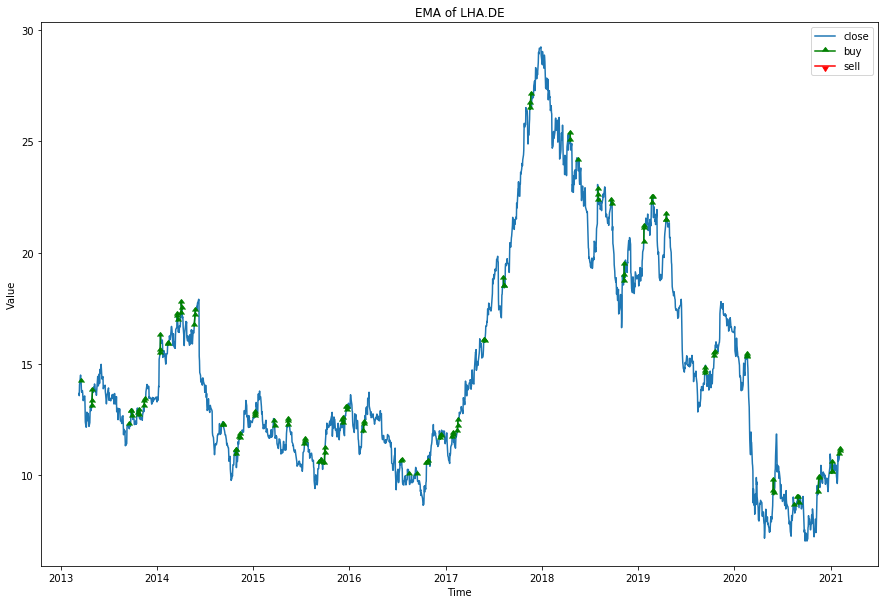

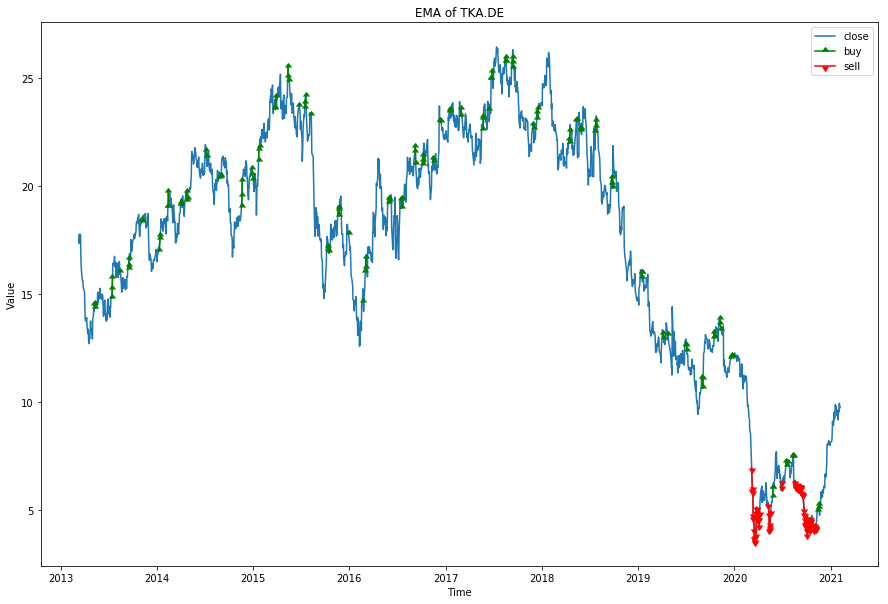

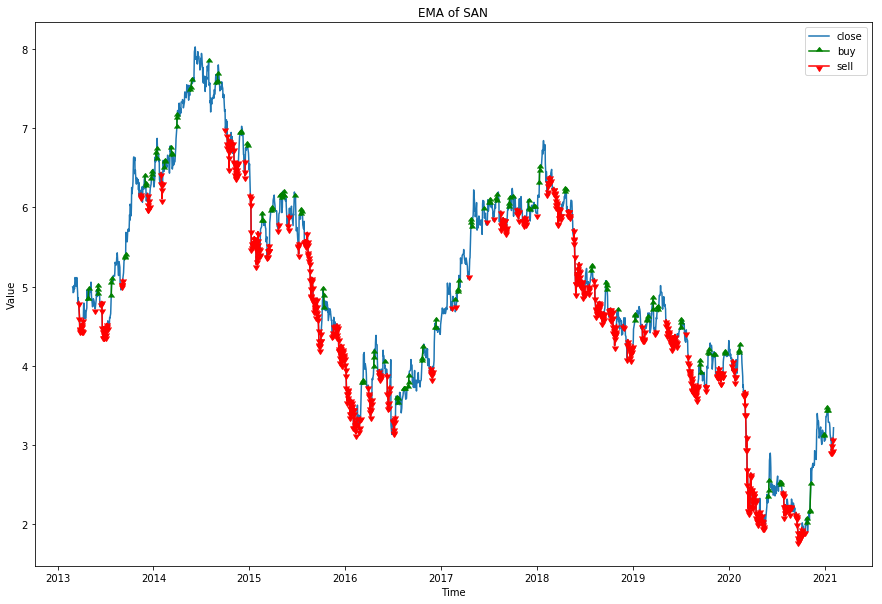

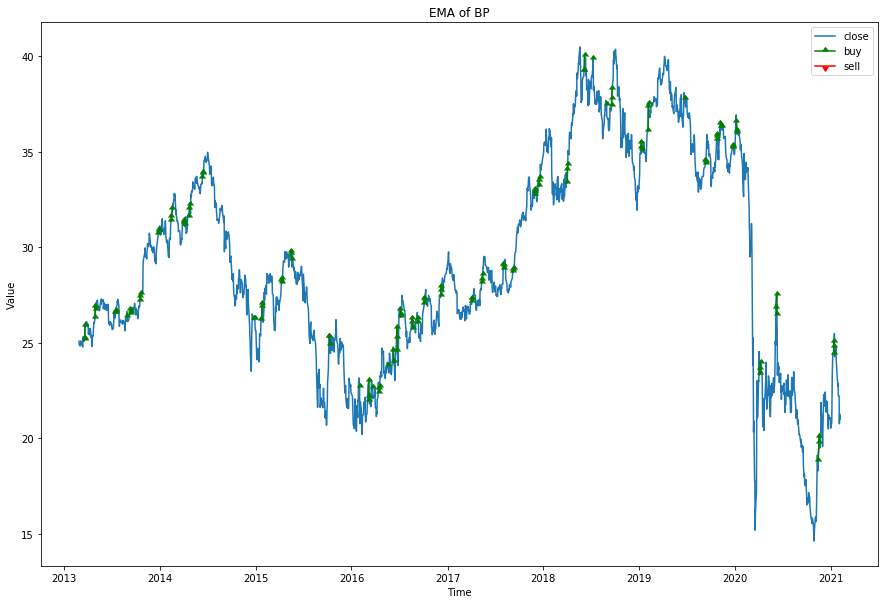

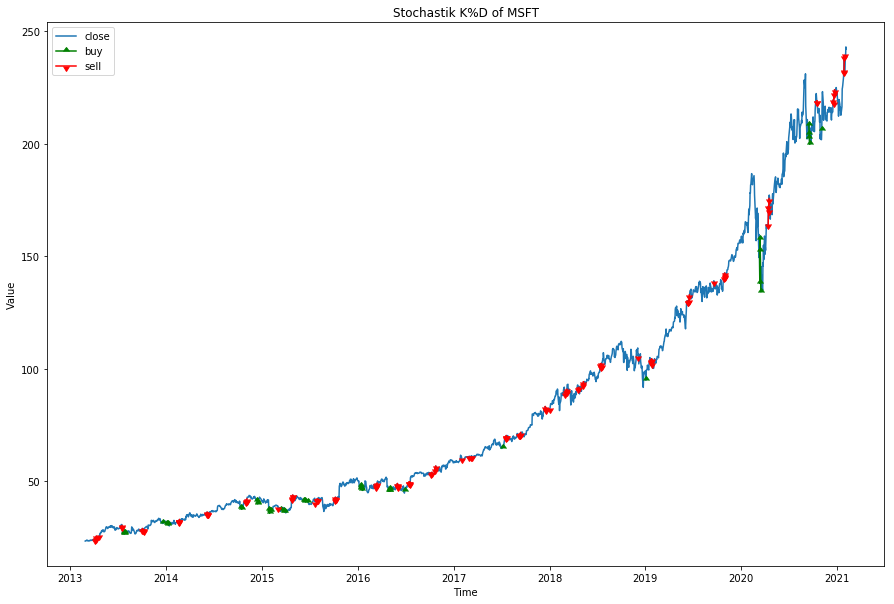

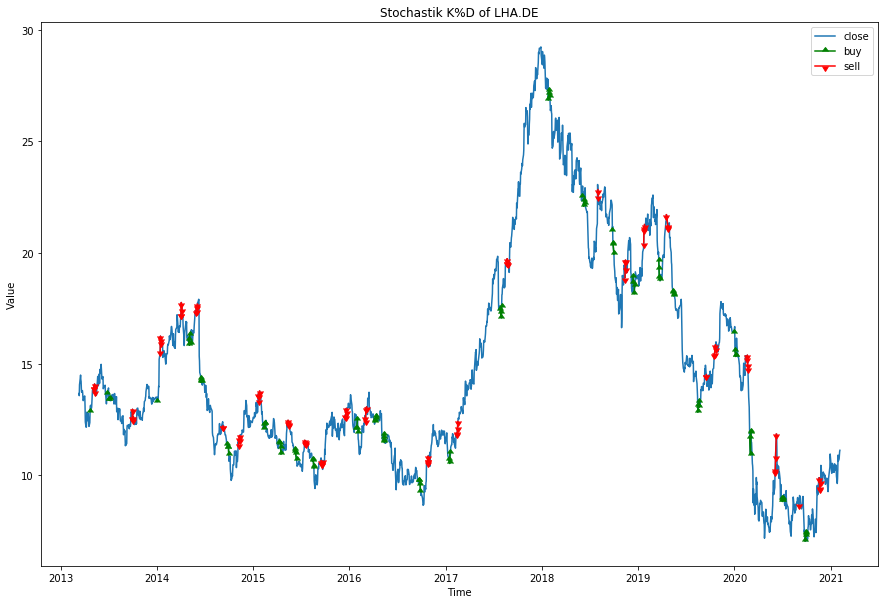

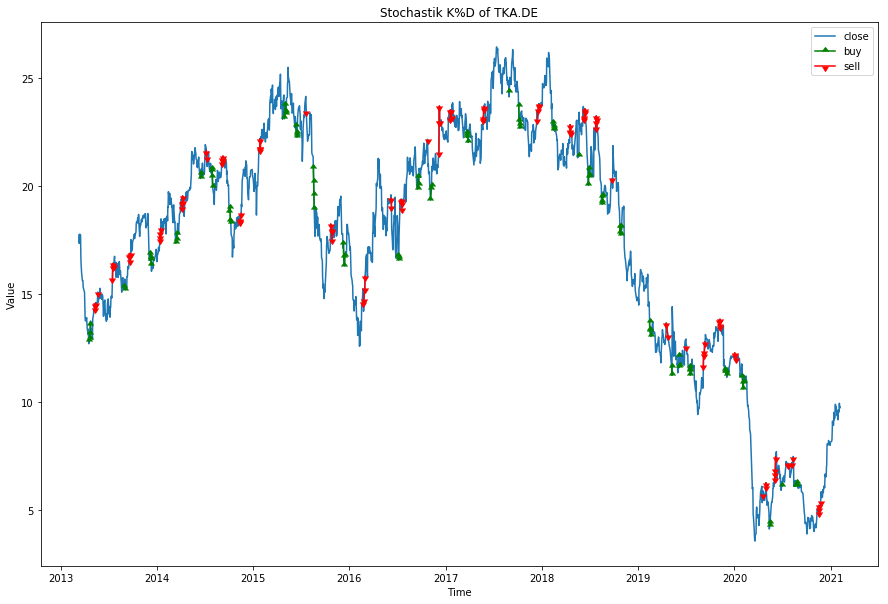

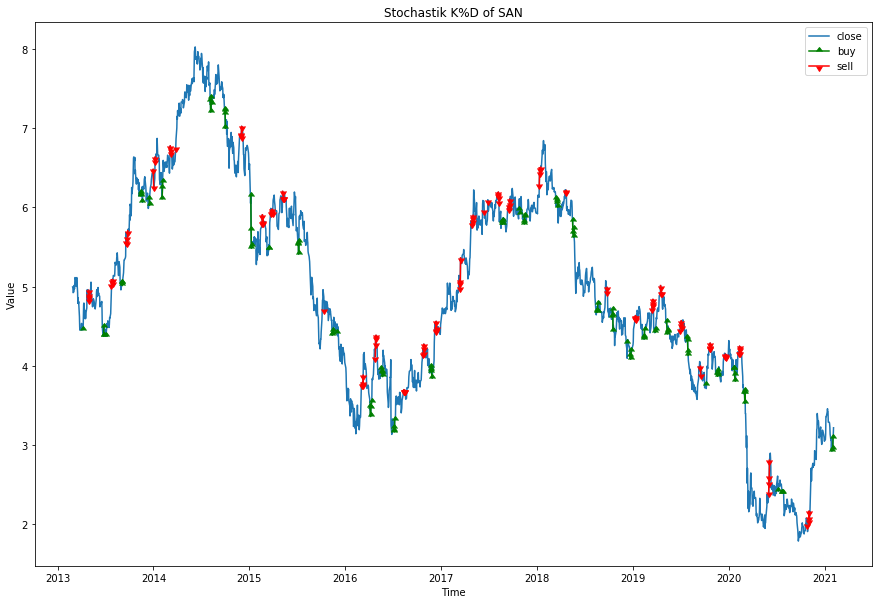

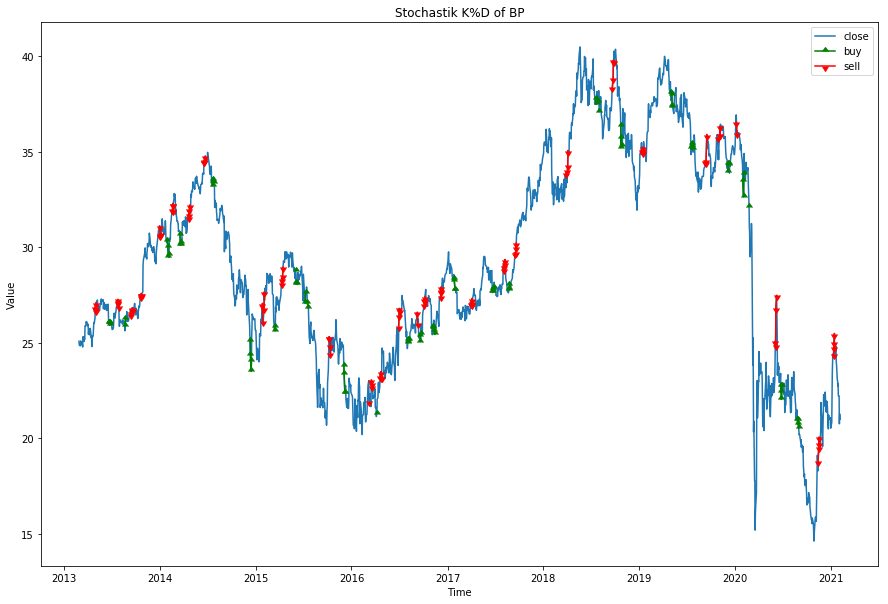

In [306]:
get_smas(stocks, names, 21)
get_rsi(stocks, names, 21)
get_macd(stocks, names, 21)
get_ema(stocks, names, 21)
get_stoch(stocks, names, 21)

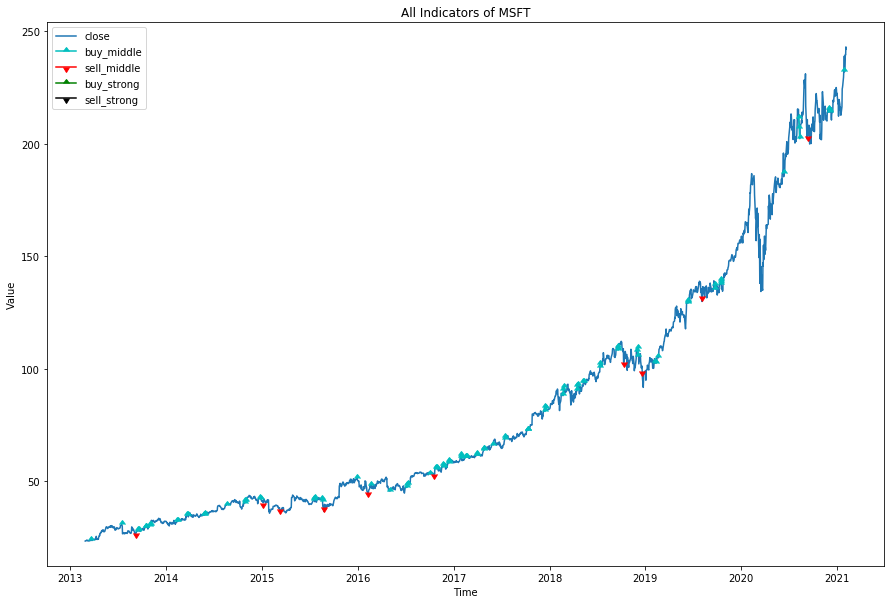

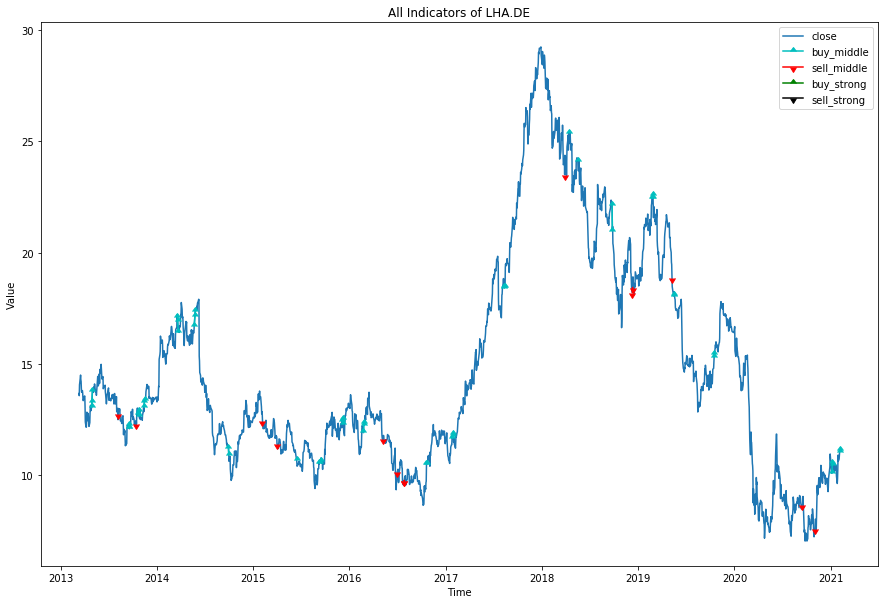

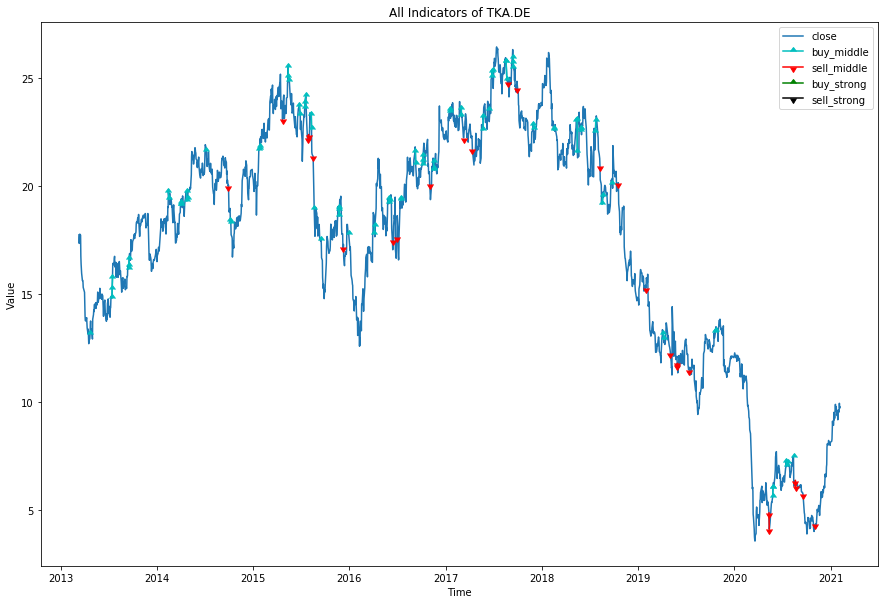

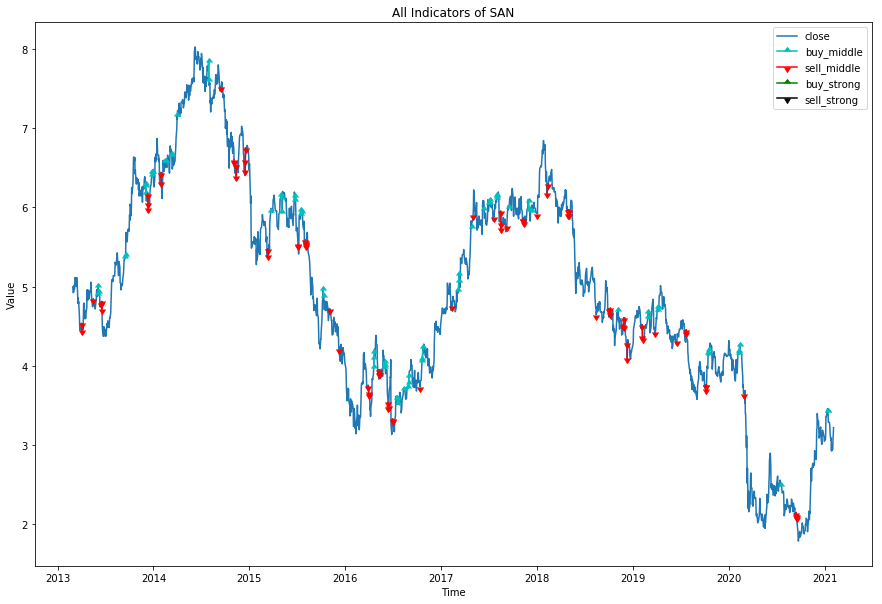

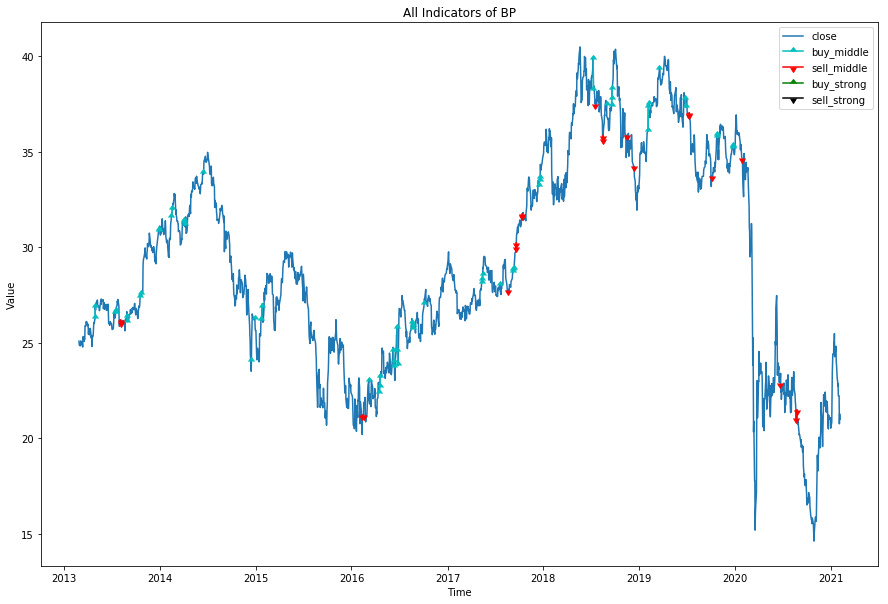

In [307]:
merge(stocks, names)

In [308]:
StartKapital = 500
Kapital = 500
Angelegt = 0
Aktien = 0
def evaluate_modell(stocks, names):
    counter = 0
    performance_gesamt = 0
    for stock in stocks:
        stock=stock[["close","buy_weak","buy_middle","buy_strong","sell_weak","sell_middle","sell_strong","hold"]]
        Aktien = 0
        Angelegt = 0 
        Kapital = 500
        #print(stock)
        length=len(stock["close"])
        #print(length)
        for day in range(length):
            #print(stock.iloc[0])
            if not (math.isnan(stock.iloc[day]["sell_weak"])) and Aktien > 0:
                Kapital,Aktien = trade(Kapital, Aktien, "sell_weak", stock.iloc[day]["sell_weak"])
            elif not (math.isnan(stock.iloc[day]["sell_middle"])) and Aktien > 0:
                Kapital,Aktien = trade(Kapital, Aktien, "sell_middle", stock.iloc[day]["sell_middle"])
            elif not (math.isnan(stock.iloc[day]["sell_strong"])) and Aktien > 0:
                Kapital,Aktien = trade(Kapital, Aktien, "sell_strong", stock.iloc[day]["sell_strong"])
            elif not (math.isnan(stock.iloc[day]["buy_weak"])):
                Kapital,Aktien = trade(Kapital, Aktien, "buy_weak", stock.iloc[day]["buy_weak"])
            elif not (math.isnan(stock.iloc[day]["buy_middle"])):
                Kapital,Aktien = trade(Kapital, Aktien, "buy_middle", stock.iloc[day]["buy_middle"])
            elif not (math.isnan(stock.iloc[day]["buy_strong"])):
                Kapital,Aktien = trade(Kapital, Aktien, "buy_strong", stock.iloc[day]["buy_strong"])
            else:
                Kapital,Aktien = trade(Kapital, Aktien, "hold", stock.iloc[day]["hold"])       
            if Kapital < 0 or Aktien < 0:
                print("that is illigal")
                print(Kapital, Aktien)
            
        print("Performance for "+names[counter])
        performance_gesamt+=print_result(Kapital, Aktien, stock.iloc[length-1:length]["close"][0])
        counter+=1
    print("Gesamtperformance: ")
    print(str(((performance_gesamt/(StartKapital*len(stocks)))-1)*100)+ "%")
def print_result(Kapital, Aktien, value):
    gesamt = Kapital + Aktien*value
    print("Vermögen gesamt: "+ str(gesamt))
    print("anstieg in Prozent: "+ str((gesamt/StartKapital-1)*100)+ " %")
    print("################################")
    return gesamt
    
def trade(Kapital, Aktien, signal, value):
    if signal == "sell_weak": 
        verkauft = round(0.15*Aktien)
        Kapital+=verkauft*value
        Aktien-=verkauft
        return Kapital, Aktien
        #print("sell_weak")
    if signal == "sell_middle":
        verkauft = round(0.35*Aktien)
        Kapital+=verkauft*value
        Aktien-=verkauft
        return Kapital, Aktien
        #print("sell_middle")
    if signal == "sell_strong":
        verkauft = round(0.7*Aktien)
        Kapital+=verkauft*value
        Aktien-=verkauft
        return Kapital, Aktien
    if signal == "buy_weak":
        kaufwert = 0.20*StartKapital
        if Kapital > round(kaufwert) and kaufwert > value:
            anzahl = math.floor(kaufwert/value)
            Kapital-=anzahl*value
            Aktien+=anzahl
            return Kapital, Aktien
        else:
            anzahl = math.floor(Kapital/value)
            Kapital-=anzahl*value
            Aktien+=anzahl
            return Kapital, Aktien
        #print("buy_weak")
    if signal == "buy_middle":
        kaufwert = 0.50*StartKapital
        if Kapital > round(kaufwert) and kaufwert > value:
            anzahl = math.floor(kaufwert/value)
            Kapital-=anzahl*value
            Aktien+=anzahl
            return Kapital, Aktien
        else:
            anzahl = math.floor(Kapital/value)
            Kapital-=anzahl*value
            Aktien+=anzahl
            return Kapital, Aktien
        #print("buy_middle")
    if signal == "buy_strong":
        kaufwert = 0.70*StartKapital
        if Kapital > round(kaufwert) and kaufwert > value:
            anzahl = math.floor(kaufwert/value)
            Kapital-=anzahl*value
            Aktien+=anzahl
            return Kapital, Aktien
        else:
            anzahl = math.floor(Kapital/value)
            Kapital-=anzahl*value
            Aktien+=anzahl
            return Kapital, Aktien            
        #print("buy_strong")
    if signal == "hold":
        return Kapital, Aktien


In [309]:
evaluate_modell(stocks, names)

Performance for MSFT
Vermögen gesamt: 4430.690275192261
anstieg in Prozent: 786.1380550384521 %
################################
Performance for LHA.DE
Vermögen gesamt: 415.19999647140503
anstieg in Prozent: -16.96000070571899 %
################################
Performance for TKA.DE
Vermögen gesamt: 383.54585552215576
anstieg in Prozent: -23.29082889556885 %
################################
Performance for SAN
Vermögen gesamt: 370.5702950954437
anstieg in Prozent: -25.885940980911258 %
################################
Performance for BP
Vermögen gesamt: 425.20856285095215
anstieg in Prozent: -14.95828742980957 %
################################
Gesamtperformance: 
141.00859940528872%


In [286]:
evaluate_modell(stocks, names)

Performance for Allianz
Vermögen gesamt: 682.6900177001953
anstieg in Prozent: 36.538003540039064 %
################################
Performance for Fresenius
Vermögen gesamt: 393.1953010559082
anstieg in Prozent: -21.360939788818357 %
################################
Performance for SAP
Vermögen gesamt: 708.505485534668
anstieg in Prozent: 41.701097106933595 %
################################
Performance for Verbund AG
Vermögen gesamt: 1214.5346403121948
anstieg in Prozent: 142.90692806243896 %
################################
Performance for Protektor Forsikring
Vermögen gesamt: 475.65797233581543
anstieg in Prozent: -4.868405532836917 %
################################
Performance for FuelCell
Vermögen gesamt: 503.2924461364746
anstieg in Prozent: 0.6584892272949228 %
################################
Performance for Newage
Vermögen gesamt: 433.2730209827423
anstieg in Prozent: -13.345395803451543 %
################################
Performance for Xiamoi
Vermögen gesamt: 513.98165452

In [230]:
evaluate_modell(stocks, names)

Performance for Allianz
Vermögen gesamt: 716.7689056396484
anstieg in Prozent: 43.35378112792969 %
################################
Performance for Fresenius
Vermögen gesamt: 357.9657211303711
anstieg in Prozent: -28.406855773925777 %
################################
Performance for SAP
Vermögen gesamt: 737.955322265625
anstieg in Prozent: 47.591064453125 %
################################
Performance for Verbund AG
Vermögen gesamt: 1421.9013042449951
anstieg in Prozent: 184.380260848999 %
################################
Performance for Protektor Forsikring
Vermögen gesamt: 447.8269920349121
anstieg in Prozent: -10.434601593017579 %
################################
Performance for FuelCell
Vermögen gesamt: 52.08050945401192
anstieg in Prozent: -89.58389810919762 %
################################
Performance for Newage
Vermögen gesamt: 330.7600154876709
anstieg in Prozent: -33.847996902465816 %
################################
Performance for Xiamoi
Vermögen gesamt: 496.78048026561737

In [171]:
round(0.3*8)

2

In [174]:
math.floor(500/100.3566)

4

In [212]:
data = yf.download("AAPL", start="2017-01-01", end="2017-04-30")
print(data)
data.hist


[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2017-01-03  28.950001  29.082500  28.690001  29.037500  27.500973  115127600
2017-01-04  28.962500  29.127501  28.937500  29.004999  27.470192   84472400
2017-01-05  28.980000  29.215000  28.952499  29.152500  27.609884   88774400
2017-01-06  29.195000  29.540001  29.117500  29.477501  27.917688  127007600
2017-01-09  29.487499  29.857500  29.485001  29.747499  28.173399  134247600
...               ...        ...        ...        ...        ...        ...
2017-04-24  35.875000  35.987499  35.794998  35.910000  34.157269   68537200
2017-04-25  35.977501  36.224998  35.967499  36.132500  34.368900   75486000
2017-04-26  36.117500  36.150002  35.845001  35.919998  34.166775   80164800
2017-04-27  35.980000  36.040001  35.827499  35.947498  34.192936   56985200
2017-04

<bound method hist_frame of                  Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2017-01-03  28.950001  29.082500  28.690001  29.037500  27.500973  115127600
2017-01-04  28.962500  29.127501  28.937500  29.004999  27.470192   84472400
2017-01-05  28.980000  29.215000  28.952499  29.152500  27.609884   88774400
2017-01-06  29.195000  29.540001  29.117500  29.477501  27.917688  127007600
2017-01-09  29.487499  29.857500  29.485001  29.747499  28.173399  134247600
...               ...        ...        ...        ...        ...        ...
2017-04-24  35.875000  35.987499  35.794998  35.910000  34.157269   68537200
2017-04-25  35.977501  36.224998  35.967499  36.132500  34.368900   75486000
2017-04-26  36.117500  36.150002  35.845001  35.919998  34.166775   80164800
2017-04-27  35.980000  36.040001  35.827499  35.947498  34.192936   56985200
2017-04-28  36.022499  36.075001  35.817501  35.

In [213]:

allianz = "Allianz"
allianz_ticker= yf.Ticker("ALV.DE")
allianz_hist = allianz_ticker.history(start="2017-01-01", end="2017-04-30")
allianz_hist = allianz_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})


In [214]:
allianz_hist

,open,high,low,close,volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-02,129.187578,130.179419,128.526347,130.014114,855478,0,0
2017-01-03,130.592692,132.328422,130.220753,131.873825,1623857,0,0
2017-01-04,132.245761,133.030968,131.873822,132.576370,1221389,0,0
2017-01-05,133.072304,133.898840,131.915159,132.824341,1469189,0,0
2017-01-06,132.369749,133.485578,131.873835,133.154968,965147,0,0
...,...,...,...,...,...,...,...
2017-04-24,143.817280,145.263718,143.651976,144.767792,2726024,0,0
2017-04-25,145.098412,145.470351,144.561156,145.057083,1399313,0,0
2017-04-26,145.057083,145.263717,144.271876,145.057083,1077907,0,0
